# Derivation of dG(r) time discretization for a model ODE problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from IPython.display import Math, display

t, k = symbols("t k")
init_printing()

In [2]:
# Choosing some value for the timestep size to visualize the basis functions
#num_elements = 1
num_elements = 2
#num_elements = 10
_T = 2. * np.pi
_k = _T / num_elements
_t = np.linspace(0., _T, 100)

## Basis functions

In the first step, we define discontinuous basis functions of degree $r$ (short: dG(r)) for our temporal discretization.

In [3]:
# HELPER FUNCTIONS

# evaluate each basis functions at the time points
# optional: scale basis by basis_coeffs
def get_basis_values(basis, basis_coeffs=None):
    if basis_coeffs is None:
        basis_coeffs = np.ones((len(basis)))
    
    # evaluate basis function at time points
    vals = [np.zeros_like(_t) for _ in range(len(basis))]
    for n in range(len(basis)):
        for i in range(_t.shape[0]):
            vals[n][i] = basis_coeffs[n] * basis[n].evalf(subs={t: _t[i], k: _k})
    
    return vals

# get linear combination of basis vector values
def get_basis_lincomb(basis, basis_coeffs):
    vals = get_basis_values(basis, basis_coeffs)
    result = np.zeros_like(vals[0])
    for n in range(len(basis)):
        result += vals[n]
    return result

# plot each basis vector
def plot_basis(basis, title=None):
    basis_vals = get_basis_values(basis)
    
    for n in range(len(basis)):
        plt.plot(_t, basis_vals[n], label=f"φ_{n}")

    plt.xlabel("t")
    plt.ylabel("f(t)")
    plt.legend()
    if title is not None:
        plt.title(title)
    plt.show()

### $dG-Q^0$

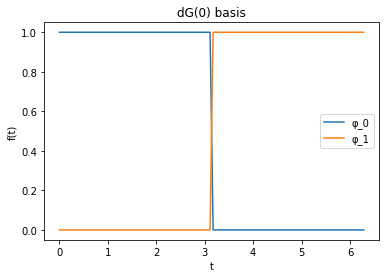

In [4]:
φ_0 = []
for n in range(num_elements):
    φ_0.append(Piecewise(
       (0, t < n*k),
       (0, t > (n+1)*k),
       (1 + 0*Id(t), True),
    ))

plot_basis(basis=φ_0, title="dG(0) basis")

### $dG-Q^1$

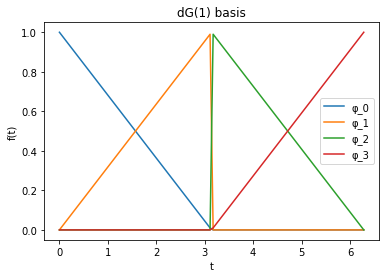

In [5]:
φ_1 = []
for n in range(num_elements):
    φ_1.append(Piecewise(
       (0, t < n*k),
       (0, t > (n+1)*k),
       (1-(t-n*k)/k, True),
    ))

    φ_1.append(Piecewise(
       (0, t < n*k),
       (0, t > (n+1)*k),
       ((t-n*k)/k, True),
    ))

plot_basis(basis=φ_1, title="dG(1) basis")

### $dG-Q^2$

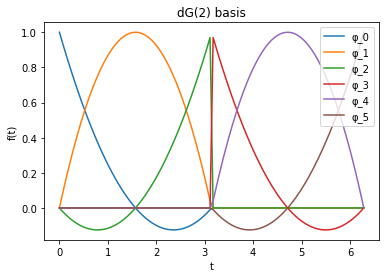

In [6]:
φ_2 = []
for n in range(num_elements):
    φ_2.append(Piecewise(
       (0, t < n*k),
       (0, t > (n+1)*k),
       ((2/k**2)*((t-n*k)-k/2)*((t-n*k)-k), True),
    ))

    φ_2.append(Piecewise(
       (0, t < n*k),
       (0, t > (n+1)*k),
       (-(4/k**2)*(t-n*k)*((t-n*k)-k), True),
    ))
    
    φ_2.append(Piecewise(
       (0, t < n*k),
       (0, t > (n+1)*k),
       ((2/k**2)*(t-n*k)*((t-n*k)-k/2), True),
    ))

plot_basis(basis=φ_2, title="dG(2) basis")

In [7]:
# dictionary of basis functions for dG(r)
φ = {0: φ_0, 1: φ_1, 2: φ_2}

## Problem statement and Galerkin discretization

We consider the model problem
$$
\partial_{tt} u(t) + u(t) = 0 \qquad \forall t \in [0,T].
$$
To make our derivations easier, we want to transform this into a first order system in time. This can be done by defining $\partial_t u = v$ and thus
$$
\begin{align}
\partial_t v(t) + u(t) &= 0, \\
\partial_t u(t) - v(t) &= 0.
\end{align}
$$

### One temporal element
Using the Galerkin ansatz $u(t) = \sum_{i = 0}^N U_i \varphi_i^u(t)$ and $v(t) = \sum_{i = 0}^N V_i \varphi_i^v(t)$ with $\varphi_i^u, \varphi_i^v \in V$ and test functions $\varphi^u, \varphi^v \in V$, we solve the weak formulation
$$
\begin{align}
(\partial_t v, \varphi^u) + (u, \varphi^u) + v(0) \cdot \varphi^u(0) &= v^0 \cdot \varphi^u(0) \qquad \forall \varphi^u \in V, \\
(\partial_t u, \varphi^v) - (v, \varphi^v) + u(0) \cdot \varphi^v(0) &= v^0 \cdot \varphi^v(0) \qquad \forall \varphi^v \in V,
\end{align}
$$
where $(f,g) := \int_0^T fg\ \mathrm{d}t$ denotes the $L^2$-inner product in time and the initial condition is directly included in the weak formulation.
This can be rewritten as the linear equation system
$$
\begin{bmatrix}
  (\varphi_0^u, \varphi_0^u) & (\partial_t \varphi_0^v, \varphi_0^u) + 1 & \dots & (\varphi_N^u, \varphi_0^u) & (\partial_t \varphi_N^v, \varphi_0^u) \\
  (\partial_t \varphi_0^u, \varphi_0^v) + 1 & - (\varphi_0^v, \varphi_0^v) & \dots & (\partial_t \varphi_N^u, \varphi_0^v) & - (\varphi_N^v, \varphi_0^v) \\
  (\varphi_0^u, \varphi_1^u) & (\partial_t \varphi_0^v, \varphi_1^u) & \dots & (\varphi_N^u, \varphi_1^u) & (\partial_t \varphi_N^v, \varphi_1^u) \\
  (\partial_t \varphi_0^u, \varphi_1^v) & - (\varphi_0^v, \varphi_1^v) & \dots & (\partial_t \varphi_N^u, \varphi_1^v) & - (\varphi_N^v, \varphi_1^v) \\
\vdots & \vdots & \vdots & \vdots \\
   (\varphi_0^u, \varphi_N^u) & (\partial_t \varphi_0^v, \varphi_N^u) & \dots &  (\varphi_N^u, \varphi_N^u) & (\partial_t \varphi_N^v, \varphi_N^u) \\
  (\partial_t \varphi_0^u, \varphi_N^v) & - (\varphi_0^v, \varphi_N^v) & \dots & (\partial_t \varphi_N^u, \varphi_N^v) & - (\varphi_N^v, \varphi_N^v) \\
\end{bmatrix}
\begin{bmatrix}
U_0 \\
V_0 \\
U_1 \\
V_1 \\
\vdots \\
U_N \\
V_N
\end{bmatrix}
= \begin{bmatrix}
U^0\\
V^0\\
0 \\
0 \\
\vdots \\
0 \\
0
\end{bmatrix},
$$
where we used that $\varphi_0^u(0) = \varphi_0^v(0) = 1$ and $\varphi_j^u(0) = \varphi_j^v(0) = 0$ for $j > 0$.

### Multiple temporal elements
We can easily extend this also to Galerkin formulation for multiple temporal elements, by adding the jump terms between the temporal elements. We define the the limits of $f$ at time $t_m$ from above and from below for a function $f$ as

$$
f_m^\pm := \lim_{\epsilon \searrow 0} f(t_m \pm \epsilon),
$$

and the jump of the function value of $f$ at time $t_m$ as

$$
[f]_m := f_m^+ - f_m^-.
$$

Let $\mathcal{T}_k := \{ I_m := (t_{m-1}, t_m) \mid 1 \leq m \leq M \}$ be a partitioning of time, i.e. $ \bar{I} = [0,T] = \bigcup_{m = 1}^M \bar{I}_m $. Then we have $M$ temporal elements and need to add jump terms when going from $I_1$ to $I_2$, from $I_2$ to $I_3$, etc.
The weak formulation for multiple temporal elements thus reads:

<FONT COLOR="#ff0000"> ToDo #1: Add the jump terms to the weak formulation.</FONT>

$$
\begin{align}
\sum_{m = 1}^M(\partial_t v, \varphi^u)_{I_m} + (u, \varphi^u)_{I_m}  \color{red}{+ ???} + v(0) \cdot \varphi^u(0) &= v^0 \cdot \varphi^u(0) \qquad \forall \varphi^u \in V, \\
\sum_{m = 1}^M(\partial_t u, \varphi^v)_{I_m} - (v, \varphi^v)_{I_m} \color{red}{+ ???} + u(0) \cdot \varphi^v(0) &= v^0 \cdot \varphi^v(0) \qquad \forall \varphi^v \in V,
\end{align}
$$
NOTE: We can also include the initial condition in the jump terms by using $u_0^+ = u(0)$, $u_0^- = u^0$, $v_0^+ = v(0)$ and $v_0^- = v^0$. Then we have
$$
\begin{align}
\sum_{m = 1}^M(\partial_t v, \varphi^u)_{I_m} + (u, \varphi^u)_{I_m}  \color{red}{+ ???} &= 0 \qquad \forall \varphi^u \in V, \\
\sum_{m = 1}^M(\partial_t u, \varphi^v)_{I_m} - (v, \varphi^v)_{I_m} \color{red}{+ ???}&= 0 \qquad \forall \varphi^v \in V.
\end{align}
$$

More concretely, we see the linear system after evaluation of the temporal integrals in the code below:

<FONT COLOR="#ff0000"> ToDo 2: Write the code for the assembly of the system matrix.</FONT>

In [8]:
def assemble_matrix(r):
    φ_r = []
    for f in φ[r]:
        φ_r.append(f) # u - basis function
        φ_r.append(f) # v - basis function
    
    matrix = []
    for n in range(len(φ_r)):
        matrix.append([0.]*len(φ_r))

    # ===============================================
    # TODO: assemble linear system as in Exercise 2 |
    # ===============================================
    # Enter code here:
    #
    
    return matrix
    
r = 1
matrix = assemble_matrix(r=r)

# print linear system
print(f"For T = {_T} and k = {_k} we get the linear system:")
latex_row = lambda matrix, row: " & ".join([latex(round(entry,6)) for entry in matrix[row]])
latex_matrix = r"\begin{pmatrix}" + r"\\".join([latex_row(matrix,i) for i in range(2*len(φ[r]))]) + r"\end{pmatrix}"
display(Math(latex_matrix + r"\begin{pmatrix}" + r"\\".join([rf"U_{i} \\ V_{i}" for i in range(len(φ[r]))]) + r"\end{pmatrix} = \begin{pmatrix} V^0 \\ U^0 \\" + r"\\".join(["0" for i in range(2,2*len(φ[r]))]) + "\end{pmatrix}"))

# HINT: Try r == 1 and num_elements == 2, if you are trying to debug your code.
if r == 1 and num_elements == 2:
    print("Matrix for debugging your code:")
    _matrix = np.zeros((8,8))
    _matrix[0,0] = _matrix[4,4] = _k / 3.
    _matrix[0,1] = _matrix[4,5] = 0.5
    _matrix[0,2] = _matrix[4,6] = _k / 6.
    _matrix[0,3] = _matrix[4,7] = 0.5
    
    _matrix[1,0] = _matrix[5,4] = 0.5
    _matrix[1,1] = _matrix[5,5] = -_k / 3.
    _matrix[1,2] = _matrix[5,6] = 0.5
    _matrix[1,3] = _matrix[5,7] = -_k / 6.
    
    _matrix[2,0] = _matrix[6,4] = _k / 6.
    _matrix[2,1] = _matrix[6,5] = -0.5
    _matrix[2,2] = _matrix[6,6] = _k / 3.
    _matrix[2,3] = _matrix[6,7] = 0.5
    
    _matrix[3,0] = _matrix[7,4] = -0.5
    _matrix[3,1] = _matrix[7,5] = -_k / 6.
    _matrix[3,2] = _matrix[7,6] = 0.5
    _matrix[3,3] = _matrix[7,7] = -_k / 3.
    
    _matrix[4,3] = -1.
    _matrix[5,2] = -1.
    
    np.set_printoptions(linewidth=150)
    print(_matrix)
    print(f"Matrices are same up to rounding errors: {np.max(np.abs(np.array(_matrix).astype('float64')-matrix)) < 1e-15}")

For T = 6.283185307179586 and k = 3.141592653589793 we get the linear system:


<IPython.core.display.Math object>

Matrix for debugging your code:
[[ 1.04719755  0.5         0.52359878  0.5         0.          0.          0.          0.        ]
 [ 0.5        -1.04719755  0.5        -0.52359878  0.          0.          0.          0.        ]
 [ 0.52359878 -0.5         1.04719755  0.5         0.          0.          0.          0.        ]
 [-0.5        -0.52359878  0.5        -1.04719755  0.          0.          0.          0.        ]
 [ 0.          0.          0.         -1.          1.04719755  0.5         0.52359878  0.5       ]
 [ 0.          0.         -1.          0.          0.5        -1.04719755  0.5        -0.52359878]
 [ 0.          0.          0.          0.          0.52359878 -0.5         1.04719755  0.5       ]
 [ 0.          0.          0.          0.         -0.5        -0.52359878  0.5        -1.04719755]]
Matrices are same up to rounding errors: False


HINT: If you need help with assembling dG(1) or dG(2) with one temporal element, try deriving the system matrix by hand using Appendix A.1 and Appendix A.2 in [FiRoWiChFa2023](https://arxiv.org/pdf/2304.01140.pdf) and use
$$
\begin{align}
M_h &= \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}, \\
K_h &= \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}.
\end{align}
$$
(Do you know why we need to use the matrices $M_h$ and $K_h$ in these derivations?)

## Solve the ODE problem with dG(r) in time

Now that we know what the linear system looks like, we have all the tools to solve the model problem $\partial_{t} v + u = 0$, $\partial_{t} u - v = 0$. For this we use the initial conditions $u(0) = 0$ and $v(0) = 1$, which means that the analytical solution is $u(t) = \sin(t)$ and $v(t) = \cos(t)$.

We now plot the solution trajectories of dG(0), dG(1) and dG(2) for $(x(t),y(t)) = (v(t), u(t))$, since the analytical solution is a parametrization of the unit circle. We add a point at the first temporal degree of freedom to better visualize where the trajectory starts. If you assembled the system matrix correctly, you should be able to observe that the dG(0) schemes, which is a variant of the backward Euler scheme, is damping the solution and spiraling inward. On the other hand, the dG(1) and dG(2) schemes are much better at capturing the dynamics and dG(2) is almost indistinguishable from the circle for `num_elements = 10`.

In [9]:
solution = {}

# solve dG(r) problems
for r in range(3):
    # assemble system matrix for dG(r)
    matrix = np.array(assemble_matrix(r=r))
    # assemble right hand side
    rhs = np.zeros((matrix.shape[0],))
    rhs[0] = 1.
    rhs[1] = 0.
    # solve linear system
    solution[r] = np.linalg.solve(matrix.astype('float64'), rhs)

# plot dG solutions and compare it with the analytical solution
plt.figure(figsize=(15,15))
plt.gca().set_aspect("equal")
colors = ["blue", "orange", "green"]
for r in range(3):
    plt.plot(get_basis_lincomb(φ[r], solution[r][1::2]), get_basis_lincomb(φ[r], solution[r][::2]), label=f"dG({r})", color=colors[r])
    plt.scatter([solution[r][1]], [solution[r][0]], color=colors[r])
plt.scatter(np.cos(_t), np.sin(_t), label="analytical", s=2, color="red")
plt.legend()
plt.show()

LinAlgError: Singular matrix